In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
import os
import torch.nn.functional as F
from tqdm import tqdm

print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
1


In [2]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 3
num_workers = 2
batch_size = 100
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 20
gamma = 0.1

In [3]:
# Teacher model definition
class TeacherCNN(nn.Module):
    def __init__(self):
        super(TeacherCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=2048, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        x = nn.ReLU()(self.fc3(x))
        x = self.fc4(x)
        return x

# Student model definition
class StudentCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=3600, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [4]:
# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Create instances of your models
teacher = TeacherCNN()
teacher.eval()  # Set teacher model to evaluation mode
student = StudentCNN()

Files already downloaded and verified


In [5]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

In [6]:
# # https://github.com/yushundong/RELIANT/blob/main/src/CPF-master/distill_dgl.py

# def fair_metric(pred, labels, sens):
#     sens = sens.cpu()
#     labels = labels.cpu()
#     idx_s0 = sens == 0
#     idx_s1 = sens == 1
#     idx_s0_y1 = idx_s0 & (labels == 1)
#     idx_s1_y1 = idx_s1 & (labels == 1)

#     if idx_s0.sum().item() == 0 or idx_s1.sum().item() == 0 or idx_s0_y1.sum().item() == 0 or idx_s1_y1.sum().item() == 0:
#         return torch.tensor(0.0), torch.tensor(0.0)  # Return zeros

#     parity = torch.abs((pred[idx_s0].sum() / (idx_s0.sum().item() + 1e-8)) - (pred[idx_s1].sum() / (idx_s1.sum().item() + 1e-8)))
#     equality = torch.abs((pred[idx_s0_y1].sum() / (idx_s0_y1.sum().item() + 1e-8)) - (pred[idx_s1_y1].sum() / (idx_s1_y1.sum().item() + 1e-8)))

#     return parity.item(), equality.item()

# def approx_loss(logits, sens, idx):
#     logits, sens, idx = logits.cpu(), sens.cpu(), idx.cpu()
#     g1 = np.argwhere(sens.numpy() == 0.0).reshape(-1)
#     g2 = np.argwhere(sens.numpy() == 1.0).reshape(-1)
#     idx_set = set(idx.numpy())
#     g1 = np.array(list(set(g1) & idx_set))
#     g2 = np.array(list(set(g2) & idx_set))

#     if g1.shape[0] == 0 or g2.shape[0] == 0:
#         return torch.tensor(0.0)  # Return zero

#     loss = torch.square(approx_func(logits[g1]).sum(axis=0) / (g1.shape[0]) - approx_func(logits[g2]).sum(axis=0) / (g2.shape[0])).sum()
#     return loss

# def approx_loss_eo(logits, sens, labels, idx):
#     logits, sens, labels, idx = logits.cpu(), sens.cpu(), labels.cpu(), idx.cpu()
#     g1 = np.argwhere(sens.numpy() == 0).reshape(-1)
#     g2 = np.argwhere(sens.numpy() == 1).reshape(-1)
#     g = np.argwhere(labels.numpy() == 1).reshape(-1)
#     idx_set = set(idx.numpy())
#     g1 = np.array(list(set(g1) & set(g) & idx_set))
#     g2 = np.array(list(set(g2) & set(g) & idx_set))
    
#     if g1.shape[0] == 0 or g2.shape[0] == 0:
#         return torch.tensor(0.0)  # Return zero 

#     loss = torch.square(approx_func(logits[g1]).sum(axis=0) / (g1.shape[0] + 1e-8) - approx_func(logits[g2]).sum(axis=0) / (g2.shape[0] + 1e-8)).sum()
#     return loss

# def approx_func(s):
#     device = s.device  # Store the device information
#     dtype = s.dtype    # Store the data type information
#     s = s.detach().cpu().numpy()
#     x = 2 * s - 1
#     result = 1 / 2 + 1 / 2 * x - 1 / 8 / 2 * (5 * x * x * x - 3 * x) + 1 / 16 / 8 * (
#                 63 * x * x * x * x * x - 70 * x * x * x + 15 * x) - 5 / 128 / 16 * (
#                        429 * x * x * x * x * x * x * x - 693 * x * x * x * x * x + 315 * x * x * x - 35 * x) + 7 / 256 / 128 * (
#                        12155 * x * x * x * x * x * x * x * x * x - 25740 * x * x * x * x * x * x * x + 18018 * x * x * x * x * x - 4620 * x * x * x + 315 * x)
#     return torch.tensor(result, device=device, dtype=dtype)


In [8]:
# Knowledge Distillation loss function
def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
    kd_loss = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction='batchmean'
    ) * (temperature * temperature)
    return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Loss computation
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        
        # Step the learning rate scheduler
        scheduler.step()
        
    print("Finished Training Teacher")



# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            
            ce_loss = criterion(student_outputs, labels)
            kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs, temperature)
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        
        scheduler.step()
        
    print("Finished Training Student")


# Call the function to train the teacher model
train_teacher(teacher, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 22%|████████████████████████████▊                                                                                                     | 111/500 [00:02<00:06, 58.51it/s]

[1, 100] loss: 4.605


 41%|█████████████████████████████████████████████████████▊                                                                            | 207/500 [00:03<00:04, 58.75it/s]

[1, 200] loss: 4.605


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 309/500 [00:05<00:03, 57.76it/s]

[1, 300] loss: 4.606


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 411/500 [00:07<00:01, 53.35it/s]

[1, 400] loss: 4.605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 55.60it/s]


[1, 500] loss: 4.605


 22%|████████████████████████████▎                                                                                                     | 109/500 [00:01<00:06, 60.51it/s]

[2, 100] loss: 4.605


 41%|█████████████████████████████████████████████████████▌                                                                            | 206/500 [00:03<00:04, 59.19it/s]

[2, 200] loss: 4.604


 62%|████████████████████████████████████████████████████████████████████████████████                                                  | 308/500 [00:05<00:03, 58.30it/s]

[2, 300] loss: 4.605


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 410/500 [00:07<00:01, 54.75it/s]

[2, 400] loss: 4.604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.04it/s]


[2, 500] loss: 4.604


 21%|███████████████████████████▊                                                                                                      | 107/500 [00:01<00:06, 58.71it/s]

[3, 100] loss: 4.604


 42%|██████████████████████████████████████████████████████▌                                                                           | 210/500 [00:03<00:04, 59.34it/s]

[3, 200] loss: 4.603


 62%|████████████████████████████████████████████████████████████████████████████████                                                  | 308/500 [00:05<00:03, 59.22it/s]

[3, 300] loss: 4.603


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 406/500 [00:07<00:01, 55.83it/s]

[3, 400] loss: 4.603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.76it/s]


[3, 500] loss: 4.603
Finished Training Teacher


 21%|███████████████████████████▊                                                                                                      | 107/500 [00:01<00:06, 58.66it/s]

[1, 100] loss: 0.625


 42%|██████████████████████████████████████████████████████▎                                                                           | 209/500 [00:03<00:05, 52.62it/s]

[1, 200] loss: 0.582


 62%|████████████████████████████████████████████████████████████████████████████████▊                                                 | 311/500 [00:05<00:03, 59.11it/s]

[1, 300] loss: 0.565


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 409/500 [00:07<00:01, 58.22it/s]

[1, 400] loss: 0.556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.37it/s]


[1, 500] loss: 0.547


 22%|████████████████████████████                                                                                                      | 108/500 [00:01<00:06, 58.76it/s]

[2, 100] loss: 0.540


 42%|██████████████████████████████████████████████████████                                                                            | 208/500 [00:03<00:05, 55.84it/s]

[2, 200] loss: 0.535


 62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 310/500 [00:05<00:03, 56.55it/s]

[2, 300] loss: 0.530


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 411/500 [00:07<00:01, 61.85it/s]

[2, 400] loss: 0.524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.37it/s]


[2, 500] loss: 0.521


 21%|███████████████████████████▊                                                                                                      | 107/500 [00:01<00:06, 59.64it/s]

[3, 100] loss: 0.516


 42%|██████████████████████████████████████████████████████▌                                                                           | 210/500 [00:03<00:04, 58.97it/s]

[3, 200] loss: 0.513


 62%|████████████████████████████████████████████████████████████████████████████████                                                  | 308/500 [00:05<00:03, 59.81it/s]

[3, 300] loss: 0.511


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 405/500 [00:06<00:01, 60.79it/s]

[3, 400] loss: 0.507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 58.76it/s]

[3, 500] loss: 0.505
Finished Training Student


In [9]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [10]:
# def compare_fairness_metrics(teacher, student, dataloader):
#     teacher.to(device)  # Ensure the teacher model is on the same device as the inputs
#     student.to(device)  # Ensure the student model is on the same device as the inputs
    
#     teacher_fairness_metrics = {'parity': [], 'equality': []}
#     student_fairness_metrics = {'parity': [], 'equality': []}

#     for inputs, labels in dataloader:
#         sensitive_attrs = labels  # Assuming label itself as a sensitive attribute
#         with torch.no_grad():
#             teacher_outputs = teacher(inputs.to(device))
#             student_outputs = student(inputs.to(device))
#         teacher_parity, teacher_equality = fair_metric(teacher_outputs, labels, sensitive_attrs)
#         student_parity, student_equality = fair_metric(student_outputs, labels, sensitive_attrs)
        
#         teacher_fairness_metrics['parity'].append(teacher_parity)
#         teacher_fairness_metrics['equality'].append(teacher_equality)
#         student_fairness_metrics['parity'].append(student_parity)
#         student_fairness_metrics['equality'].append(student_equality)

#     # Computing the average for each metric
#     teacher_avg_fairness = {key: sum(values)/len(values) for key, values in teacher_fairness_metrics.items()}
#     student_avg_fairness = {key: sum(values)/len(values) for key, values in student_fairness_metrics.items()}
    
#     return teacher_avg_fairness, student_avg_fairness

# # Then, when you call this function:
# teacher_fairness_metrics, student_fairness_metrics = compare_fairness_metrics(teacher, student, trainloader)

In [11]:
# def adversarial_train_model(model, dataloader, criterion, optimizer, epoch, loss_log, combined_loss_log, fairness_penalty_sp_log, fairness_penalty_eo_log, fairness_penalty_approx_log, fairness_penalty_approx_eo_log, epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log):
#     model.to(device)
#     model.train()
#     running_loss = 0.0
#     progress_bar = tqdm(enumerate(dataloader, 0), total=len(dataloader), unit="batch")
#     for i, data in progress_bar:
#         inputs, labels = data
#         sensitive_attrs = labels  # Assuming label itself as a sensitive attribute
#         optimizer.zero_grad()
#         outputs = model(inputs.to(device))
#         loss = criterion(outputs, labels.to(device))
#         # Incorporate fairness metrics
#         fairness_penalty_sp, fairness_penalty_eo = fair_metric(outputs, labels, sensitive_attrs)
#         fairness_penalty_approx = approx_loss(outputs, sensitive_attrs, torch.arange(len(labels)).to(device))
#         fairness_penalty_approx_eo = approx_loss_eo(outputs, sensitive_attrs, labels, torch.arange(len(labels)).to(device))
#         combined_loss = loss + fairness_penalty_sp + fairness_penalty_eo + fairness_penalty_approx + fairness_penalty_approx_eo

#         progress_bar.set_postfix(
#             combined_loss=combined_loss.item(),
#             fairness_penalty_sp=fairness_penalty_sp,
#             fairness_penalty_eo=fairness_penalty_eo,
#             fairness_penalty_approx=fairness_penalty_approx.item(),
#             fairness_penalty_approx_eo=fairness_penalty_approx_eo.item()
#         )
#         combined_loss.backward()
#         optimizer.step()
#         running_loss += combined_loss.item()
#         progress_bar.set_description(f"Epoch {epoch} Loss: {running_loss/(i+1):.4f}")
        
#         # Logging the losses
#         loss_log.append(loss.item())
#         combined_loss_log.append(combined_loss.item())
#         fairness_penalty_sp_log.append(fairness_penalty_sp)
#         fairness_penalty_eo_log.append(fairness_penalty_eo)
#         fairness_penalty_approx_log.append(fairness_penalty_approx.item())
#         fairness_penalty_approx_eo_log.append(fairness_penalty_approx_eo.item())

#     # Print the loss components and total loss after each epoch
#     print(f'Epoch {epoch + 1} Loss Components:')
#     print(f'Total Loss: {running_loss / len(dataloader):.4f}')
#     print(f'Cross-Entropy Loss: {sum(loss_log) / len(loss_log):.4f}')
#     print(f'SP Fairness Penalty: {sum(fairness_penalty_sp_log) / len(fairness_penalty_sp_log):.4f}')
#     print(f'EO Fairness Penalty: {sum(fairness_penalty_eo_log) / len(fairness_penalty_eo_log):.4f}')
#     print(f'Approx Fairness Penalty: {sum(fairness_penalty_approx_log) / len(fairness_penalty_approx_log):.4f}')
#     print(f'Approx EO Fairness Penalty: {sum(fairness_penalty_approx_eo_log) / len(fairness_penalty_approx_eo_log):.4f}')

#     # Append the average loss values to the epoch logging lists
#     epoch_loss_log.append(sum(loss_log) / len(loss_log))
#     epoch_combined_loss_log.append(running_loss / len(dataloader))
#     epoch_fairness_penalty_sp_log.append(sum(fairness_penalty_sp_log) / len(fairness_penalty_sp_log))
#     epoch_fairness_penalty_eo_log.append(sum(fairness_penalty_eo_log) / len(fairness_penalty_eo_log))
#     epoch_fairness_penalty_approx_log.append(sum(fairness_penalty_approx_log) / len(fairness_penalty_approx_log))
#     epoch_fairness_penalty_approx_eo_log.append(sum(fairness_penalty_approx_eo_log) / len(fairness_penalty_approx_eo_log))

#     return running_loss / len(dataloader)
    
# # Define the logging lists at the beginning of your script or before the training loop
# teacher_loss_log, teacher_combined_loss_log, teacher_fairness_penalty_sp_log, teacher_fairness_penalty_eo_log, teacher_fairness_penalty_approx_log, teacher_fairness_penalty_approx_eo_log = [], [], [], [], [], []
# student_loss_log, student_combined_loss_log, student_fairness_penalty_sp_log, student_fairness_penalty_eo_log, student_fairness_penalty_approx_log, student_fairness_penalty_approx_eo_log = [], [], [], [], [], []

# # Define the missing epoch logging lists
# epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log = [], [], [], [], [], []

# # Train your model with adversarial training
# for epoch in range(num_epochs):
#     adversarial_train_model(student, trainloader, criterion, optimizer, epoch, student_loss_log, student_combined_loss_log, student_fairness_penalty_sp_log, student_fairness_penalty_eo_log, student_fairness_penalty_approx_log, student_fairness_penalty_approx_eo_log, epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log)


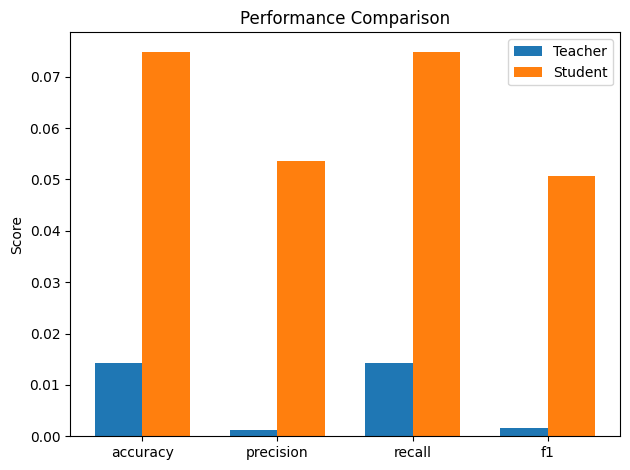

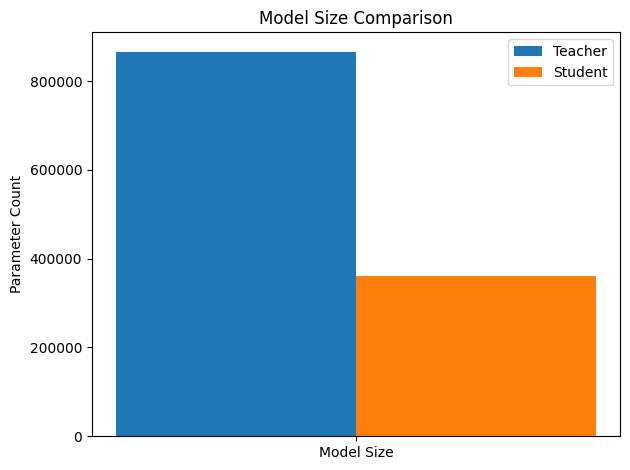

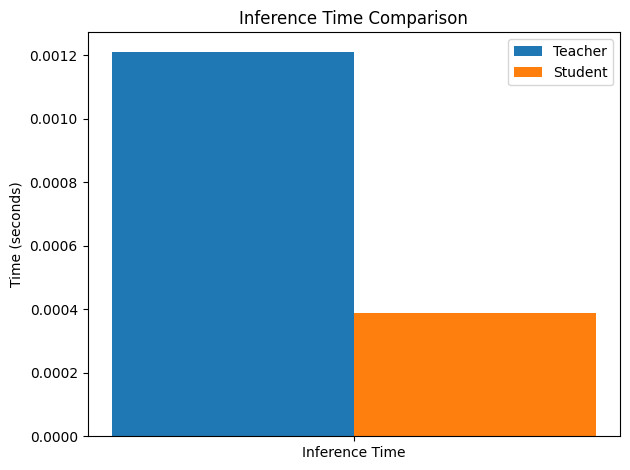

In [15]:
# Comparing the models
teacher_params, student_params = compare_model_size(teacher, student)
teacher_time, student_time = compare_inference_time(teacher, student, trainloader)
performance_metrics = compare_performance_metrics(teacher, student, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (seconds)')

In [13]:
# epochs = list(range(1, num_epochs + 1))  # Create a list of epoch numbers

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, epoch_combined_loss_log, label='Total Loss')
# plt.plot(epochs, epoch_loss_log, label='Cross-Entropy Loss')
# plt.plot(epochs, epoch_fairness_penalty_sp_log, label='SP Fairness Penalty')
# plt.plot(epochs, epoch_fairness_penalty_eo_log, label='EO Fairness Penalty')
# plt.plot(epochs, epoch_fairness_penalty_approx_log, label='Approx Fairness Penalty')
# plt.plot(epochs, epoch_fairness_penalty_approx_eo_log, label='Approx EO Fairness Penalty')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss and Loss Components per Epoch')
# plt.show()

In [16]:
# Save the student model architecture and weights
torch.save(student.state_dict(), 'student_model.pth')
torch.save(teacher.state_dict(), 'teacher_model.pth')

# Define your model architectures as strings
teacher_arch = '''
class TeacherCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(TeacherCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=2048, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        x = nn.ReLU()(self.fc3(x))
        x = self.fc4(x)
        return x
'''

student_arch = '''
class StudentCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=3600, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
'''

# Open model_arch.py in write mode
with open('model_arch.py', 'w') as file:
    # Write the model architectures to model_arch.py
    file.write(teacher_arch)
    file.write(student_arch)
